# Classifying Pneumonia

# ABSTRACT

Chest x-ray images gathered from Guangzhou Women and Children’s Medical Center are used to create a machine learning model that helps identify the precense of pneumonia in a patient. These images have been resized and vectorized to be the input for two models. A logistic regression model and a central neural network model were used to create classifications of patients and their well-being. These models would be evaluated based on accuracy. The resulting model would be able to correctly identify pneumonia in a chest x-ray with 79% accuracy.

# Business Problem 

Doctors have many methods to detect the precense of infections but not all are conclusive. Pneumonia is an infection in the lungs that affects millions every year and can be identified through chest x-rays. While chest x-rays are useful ways to identify pneumonia, the indicators of the infection can be difficult to spot. Doctors also tend to numerous patients and may need to prioritize one over another. A tool to help classify which patients are not afflicted with pneumonia would help doctors focus on those who need urgent care

A machine learning model that accepts chest x-rays as inputs can be trained to identify patterns of pneumonia and classify patients into two categories: ‘have pneumonia’ or ‘does not have pneumonia

# Data Understanding 

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

The Chest X-ray images are of pediatric patients one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. The dataset has been pre-screened for quality control and only contains high quality X-rays for the neural network to learn on. All unreadable or low quality images have already been removed. Three expert physicians diagnosed each of the images the categorization of whether a patients X-ray is positive for pneumonia or not. 

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal).\
5,856 Total X-Ray images (JPEG) and 2 categories (Pneumonia/Normal)\
3,867 X-Ray images depicting pneumonia\
1,349 healthy X-Ray images \


## Global variables

In [2]:
train_data_dir = 'chest_xray/train/'
val_data_dir = 'chest_xray/val/'
test_data_dir = 'chest_xray/test/'

image_x_size = 500
image_y_size = 500

train_batch_size = 5216
val_batch_size = 16
test_batch_size = 624

In [3]:
val_generator = ImageDataGenerator().flow_from_directory(
        val_data_dir, 
        target_size=(image_x_size, image_y_size), batch_size=val_batch_size)

train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(image_x_size, image_y_size), batch_size=train_batch_size)

test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(image_x_size, image_y_size), batch_size=test_batch_size)

# Create the datasets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Sample Images

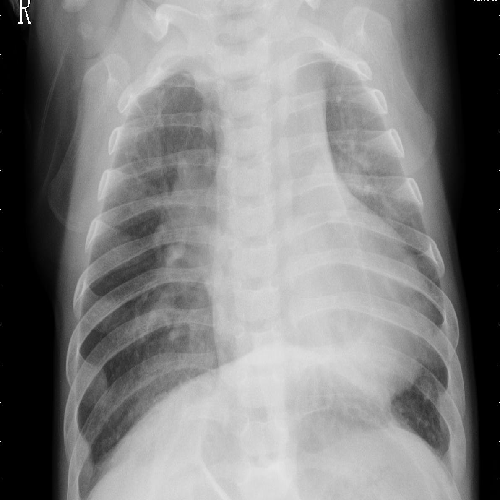

In [4]:
array_to_img(train_images[10])

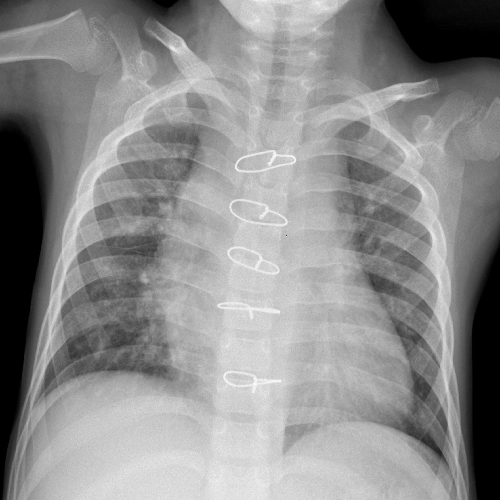

In [5]:
array_to_img(train_images[130])

# Data Preparation

We need to preprocess our data before it can be run through a neural network model.\

In [6]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(val_images))
print(np.shape(val_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(5216, 500, 500, 3)
(5216, 2)
(16, 500, 500, 3)
(16, 2)
(624, 500, 500, 3)
(624, 2)


##  `train_images`, `val_images` and `test_images`

Start with unrowing the train, validation and test images by reshaping them into an $n$ x $l$ shape.\
This will transform the image shapes from $(xxxx, 500, 500, 3)$ to $(xxxx, 750000)$

In [7]:
# Reshape the train images 
train_img_unrow = train_images.reshape(train_batch_size, -1).T
np.shape(train_img_unrow)

(750000, 5216)

transform `val_images` 

In [8]:
# Reshape the val images 
val_img_unrow = val_images.reshape(val_batch_size, -1).T

In [9]:
# Preview the shape of val_img_unrow
np.shape(val_img_unrow)

(750000, 16)

transform `test_images` in a similar way.

In [10]:
# Define appropriate m 
test_img_unrow = test_images.reshape(test_batch_size, -1).T

In [11]:
# Preview the shape of test_img_unrow
np.shape(test_img_unrow)

(750000, 624)

# `train_labels`, `val_labels` and `test_labels`

We need to check that the train, validation and test labels correspond with `pneumonia` and `healthy`

In [12]:
train_labels.shape,val_labels.shape, test_labels.shape

((5216, 2), (16, 2), (624, 2))

In [13]:
train_labels

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [14]:
# this was stored using keras.preprocessing_image, and you can get more info using the command train_generator.class_indices
train_generator.class_indices, val_generator.class_indices, test_generator.class_indices

({'NORMAL': 0, 'PNEUMONIA': 1},
 {'NORMAL': 0, 'PNEUMONIA': 1},
 {'NORMAL': 0, 'PNEUMONIA': 1})

In [15]:
train_labels_final = train_labels.T[[1]]

In [16]:
np.shape(train_labels_final)

(1, 5216)

In [17]:
val_labels_final = val_labels.T[[1]]
np.shape(val_labels_final)

(1, 16)

In [18]:
test_labels_final = test_labels.T[[1]]

In [19]:
np.shape(test_labels_final)

(1, 624)

1. First, use array_to_image() again on the original train_images with index 240 to look at this particular image
2. Use train_labels_final to get the 240th label

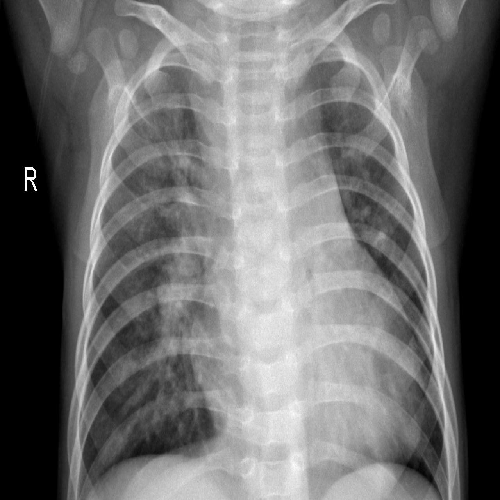

In [20]:
array_to_img(train_images[240])

In [21]:
train_labels_final[:,240]

array([1.], dtype=float32)

## Standardize the data

Since this is a deep learning model, we want to make sure each pixel value is between 0 and 1. Therefore we  divide the entire matrix by 255 for the `train_img_unrow`,`val_img_unrow` and `test_img_unrow`. 

In [22]:
train_img_final = train_img_unrow/255
val_img_final = val_img_unrow/255
test_img_final = test_img_unrow/255

type(train_img_unrow)

numpy.ndarray

In [23]:
train_img_final.shape

(750000, 5216)

# CNN

In [24]:
# Define size we want to load out image from
image_x_size = 64
image_y_size = 64

In [25]:
val_generator = ImageDataGenerator().flow_from_directory(
        val_data_dir, 
        target_size=(image_x_size, image_y_size), batch_size=val_batch_size)

train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(image_x_size, image_y_size), batch_size=train_batch_size)

test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(image_x_size, image_y_size), batch_size=test_batch_size)

# Create the datasets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [26]:
# Standardize the data
train_images_mlp = (train_images / 255).astype('float32')
val_images_mlp = (val_images / 255).astype('float32')
test_images_mlp = (test_images / 255).astype('float32')

MLP Model Iterations

Our first model starts off with a convultional layer to read our RGB image. We define the number of filters, kernel_size, strides, activation function, padding (not necessary), input shape (x, y, 3), and the data_format ('channels_last' just means our RGB values are in the last index).

Keeping it simple, we defined kernel_size as (2, 2) and strides as (1, 1).

More filters the better, so we began our model at 32 filters.

Activation function was set to 'relu'.

The MaxPooling2D layer compresses, then enhances the image. 

We set the pool_size = (2, 2)
and strides = 2.

The next layer flattens the image, meaning transforming our data into a 1D array, scaling the RGB values. 

The first Dense layer is the number of neurons that will predict upon the flattened 1D array. This layer is extremely important as its job is to condense a large amount of information into the number of neurons we defince, in this case '128''. We give it an activation function, 'relu' before adding another Dense layer of size 2 with activation 'sigmoid'.

In [27]:
# Build the model with multiple hidden layers
model_1 = models.Sequential()
model_1.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(image_x_size, image_y_size, 3),
                        data_format = 'channels_last'))
model_1.add(layers.MaxPooling2D(pool_size=(2,2),
                     strides=2))
model_1.add(layers.Flatten())        
model_1.add(layers.Dense(128))
model_1.add(layers.Activation('relu'))
model_1.add(layers.Dense(2))
model_1.add(layers.Activation('sigmoid'))

The summary function shows how the data is transformed over time through the 'Output Shape' column.

In [28]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        

We use the compile function to define the optimizer (adam), loss cost (binary_crossentropy), and metric (accuracy) we want to score.

In [29]:
# Define an optimizer, cost lost function, and scoring metric
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
model_1.fit(train_images_mlp, train_labels, epochs=5, batch_size=50)

Epoch 1/5
105/105 [==============================] - 5s 42ms/step - loss: 0.3435 - accuracy: 0.8648
Epoch 2/5
105/105 [==============================] - 4s 39ms/step - loss: 0.1175 - accuracy: 0.9551
Epoch 3/5
105/105 [==============================] - 4s 41ms/step - loss: 0.0771 - accuracy: 0.9739
Epoch 4/5
105/105 [==============================] - 4s 40ms/step - loss: 0.0667 - accuracy: 0.9766
Epoch 5/5
105/105 [==============================] - 4s 38ms/step - loss: 0.0703 - accuracy: 0.9747


Then, pass in our training data and define hyperparameters epoch and batch_size.

Finally, evaluate on our validation data:

In [31]:
val_loss, val_acc = model_1.evaluate(val_images_mlp, val_labels)

1/1 [==============================] - 0s 117ms/step - loss: 0.2407 - accuracy: 0.8750


Our training accuracy seems to be extremely good at 98, however our validation score was 75%, a drop of over 20%! 

Our model seems to not be as good at capturing all the data after we flatten our image. Lets see if increasing the neurons in that layer helps our validation accuracy.

At 512 Neurons:


In [32]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        strides=(1,1),
                        activation='relu',
                        padding = 'same',
                        input_shape=(image_x_size, image_y_size, 3),
                        data_format = 'channels_last'))
model_2.add(layers.MaxPooling2D(pool_size=(2,2),
                     strides=2))
model_2.add(layers.Flatten())        
model_2.add(layers.Dense(512))
model_2.add(layers.Activation('relu'))
model_2.add(layers.Dense(2))
model_2.add(layers.Activation('sigmoid'))
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               16777728  
                                                                 
 activation_2 (Activation)   (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                      

In [33]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_2.fit(train_images_mlp, train_labels, epochs=5, batch_size=50)

Epoch 1/5
105/105 [==============================] - 8s 77ms/step - loss: 0.3679 - accuracy: 0.8846
Epoch 2/5
105/105 [==============================] - 8s 76ms/step - loss: 0.1006 - accuracy: 0.9664
Epoch 3/5
105/105 [==============================] - 8s 75ms/step - loss: 0.0965 - accuracy: 0.9649
Epoch 4/5
105/105 [==============================] - 8s 74ms/step - loss: 0.0688 - accuracy: 0.9737
Epoch 5/5
105/105 [==============================] - 8s 72ms/step - loss: 0.0488 - accuracy: 0.9822


In [34]:
val_loss, val_acc = model_2.evaluate(val_images_mlp, val_labels)

1/1 [==============================] - 0s 90ms/step - loss: 0.7911 - accuracy: 0.6875


We were successful in underfitting our model, but there is still a large overfitting problem happening with our model. We could keep increasing the number of neurons in hopes of underfitting more, but a different model may yield better results.

## Build a logistic regression-based neural network

   - Initialize the parameters of the model
   - Perform forward propagation, and calculate the current loss
   - Perform backward propagation (which is basically calculating the current gradient)
   - Update the parameters (gradient descent)

The cost function is then given by:
$$J(w,b) = \dfrac{1}{l}\displaystyle\sum^l_{i=1}\mathcal{L}(\hat y^{(i)}, y^{(i)})$$

$w$ and $b$ are the unknown parameters to start with: 
- remember that $b$ is a scalar
- $w$ however, is a vector of shape $n$ x $1$, with $n$ being `horizontal_pixel x vertical_pixel x 3`

# Baseline - Logistic Regression

Using gradient descent

In [45]:
image_x_size = 500
image_y_size = 500

In [46]:
# Initialize empty array with size n
def init_w(n):
    w = np.zeros((n, 1))
    return w

In [47]:
b = 0

In [48]:
w = init_w(image_x_size*image_y_size*3)

#### Forward Propagation

In [49]:
def propagation(w, b, x, y):
    l = x.shape[1]
    y_hat = 1/(1 + np.exp(- (np.dot(w.T, x) + b)))                                  
    cost = -(1/l) * np.sum(y * np.log(y_hat) + (1-y)* np.log(1 - y_hat))    
    dw = (1/l) * np.dot(x,(y_hat - y).T)
    db = (1/l) * np.sum(y_hat - y)
    return dw, db, cost

In [50]:
dw, db, cost = propagation(w, b, train_img_final, train_labels_final)

In [51]:
print(dw)

print(db)

print(cost)

[[-0.05008308]
 [-0.05008308]
 [-0.05008308]
 ...
 [-0.03565237]
 [-0.03565237]
 [-0.03565237]]
-0.2429064417177914
0.6931471805599453


#### Optimization

$$w := w - \alpha * dw$$
$$b := b - \alpha * db$$

In [52]:
def optimization(w, b, x, y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        dw, db, cost = propagation(w, b, x, y)    
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs and print them every 50 iterations
        if i % 50 == 0:
            costs.append(cost)
        if print_cost and i % 50 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    return w, b, costs

#### Predictions

In [53]:
def prediction(w, b, x):
    l = x.shape[1]
    y_prediction = np.zeros((1, l))
    w = w.reshape(x.shape[0], 1)
    y_hat = 1/(1 + np.exp(- (np.dot(w.T, x) + b))) 
    p = y_hat
    
    # Define our cutoff for 'True' for pneumonia, set at 50%.
    for i in range(y_hat.shape[1]):
        if (y_hat[0,i] > 0.5): 
            y_prediction[0, i] = 1
        else:
            y_prediction[0, i] = 0
    return y_prediction

## Overall Model - Baseline

In [54]:
def model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    b = 0
    w = init_w(np.shape(x_train)[0]) 

    # Gradient descent (≈ 1 line of code)
    w, b, costs = optimization(w, b, x_train, y_train, num_iterations, learning_rate, print_cost)
    
    y_pred_test = prediction(w, b, x_test)
    y_pred_train = prediction(w, b, x_train)

    # Print train/test errors
    print('train accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    output = {'costs': costs, 
              'y_pred_test': y_pred_test,  
              'y_pred_train' : y_pred_train,  
              'w' : w, 
              'b' : b, 
              'learning_rate' : learning_rate, 
              'num_iterations': num_iterations}
    
    return output

#### Using Train and Val

Began our model to train our model at 500 iterations with a learning rate of 0.01. 

In [ ]:
# Baseline - Baseline. 500 iterations at 0.01 learning rate
output = model(train_img_final, train_labels_final, val_img_final, val_labels_final, 
               num_iterations=500, learning_rate=0.01, print_cost=False)

C:\Users\Jakub\AppData\Local\Temp/ipykernel_9400/3547166593.py:4: RuntimeWarning: divide by zero encountered in log
  cost = -(1/l) * np.sum(y * np.log(y_hat) + (1-y)* np.log(1 - y_hat))
C:\Users\Jakub\AppData\Local\Temp/ipykernel_9400/3547166593.py:4: RuntimeWarning: invalid value encountered in multiply
  cost = -(1/l) * np.sum(y * np.log(y_hat) + (1-y)* np.log(1 - y_hat))


<br> train: 95%
<br> test: 87.5%
<br>With a difference of 7.5%, between our train and test, overfitting is a problem with our model. Lets see if we can reduce that.

300 iterations at 0.01 learning rate:


In [ ]:
# Possibly overfitting, a lower number of iterations - at 300 - underfits our model by a tad, but not much
output = model(train_img_final, train_labels_final, val_img_final, val_labels_final, 
               num_iterations=300, learning_rate=0.01, print_cost=True)

train: 94.2%
<br>test: 87.5%

We reduced overfitting, but only by 1%. Lets see if we can reduce overfiting further by decreasing the iterations once again, but also decreasing the learning rate.

<br>200 iterations at 0.005 learning rate:

In [ ]:
# Decrease the learning rate while also lowering the number of iterations made our model fit not as much, but our metric 
# scores decreased drastically
output = model(train_img_final, train_labels_final, val_img_final, val_labels_final, 
               num_iterations=200, learning_rate=0.005, print_cost=True)

train: 92.4%
<br>test: 81.25%
<br>We successfully lowered the training accuracy, however our testing accuracy also took a substantial hit, making our model worse overall.

<br>In this final iteration, we kept the low number of iterations at 200, but increased the learning rate back up to 0.01.

In [ ]:
output = model(train_img_final, train_labels_final, val_img_final, val_labels_final, 
               num_iterations=200, learning_rate=0.01, print_cost=True)

<br>test: 93%
<br>train: 87.5%

This seems to be the best overall hyper-parameters to lower overfitting while retaining most most of the predictive power. 
We scored our final model on the test set to see our final model's accuracy.

In [ ]:
output = model(train_img_final, train_labels_final, test_img_final, test_labels_final, 
               num_iterations=200, learning_rate=0.01, print_cost=True)

# Evaluation 

The Evaluation Metric we decided was the most important was accuracy. Because this tool's primary function is to assist doctor's and improve their accuracy in classifying pneumonia.

Overfitting to our training data is a existent in both, but both models score similarily in accuracy score.

# Data Limitations

Because the images we used to train our model on is a general x-ray images labeled 'PNEUMONIA' and 'NORMAL', we do not have additional data about the patient. For example, if the patient has a pre-existing condition, how long they had pneumonia for, if they ever had pneumonia but recoverd, etc.

Images with a higher resolution will also help train our model to decipher pneumonia better.

Lastly, because our sample was limited to children ages 1-5 obtained from Ghangzhou, China, collecting samples from different geographical locations would be an important step.

The addition of any of these features will improve our model’s classification accuracy

# Conclusion 

Due to the similiar metrics, we decided to choose the Logistic Regression model as our final model. Logistic Regression is much simplier to interpret and explain versus a blackbox model such as the Multi-Layer-Perceptron model. Especially in a medical field where explainability holds heavy value.

Do note that our model is 79% accurate, meaning it should NOT replace a doctor's diagnosis, but rather to use in tandem with a doctor's opinion.

This tool may ultimately aid in expediting the diagnosis and referral of these treatable conditions, thereby facilitating earlier treatment, resulting in improved clinical outcomes.